<a href="https://colab.research.google.com/github/sambshade/CNN_Project_Histopathologic_Cancer_Detection/blob/main/CNN_Project_for_Histopathologic_Cancer_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histopathalogic Cancer Detection:

The objective of this project is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The dataset for this project is a slightly modified version of PatchCamelyon (PCAM) benchmark dataset: https://github.com/basveeling/pcam. This project is part of the Kaggle Competition which is detailed in the following link: https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview.

In [1]:
# Import Libraries

# To organize the input files
import zipfile
import os

# For math functions and plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# For splitting train/test data
from sklearn.model_selection import train_test_split

# Tensorflow for CNN Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [5]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [04:48<00:00, 24.3MB/s]
100% 6.31G/6.31G [04:48<00:00, 23.4MB/s]


In [7]:
zip_file = "/content/histopathologic-cancer-detection.zip"
destination_folder = "histopathologic-cancer-detection"

with zipfile.ZipFile(zip_file, "r") as zip_ref:
  zip_ref.extractall(destination_folder)

print(f"Dataset extracted to {destination_folder}")

Dataset extracted to histopathologic-cancer-detection


In [8]:
# Pull the labels csv from the destination folder created; verify it exists
# and save to dataframe titled `labels`. Observe first five rows of `labels`
labels_csv = os.path.join(destination_folder, "train_labels.csv")
if os.path.exists(labels_csv):
  labels = pd.read_csv(labels_csv)
  print(labels.head())
else:
  print("Labels CSV not found.")

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


### Exploratory Data Analysis (EDA):
The EDA process includes examining the shape of the `labels` dataframe, gathering general information via the `.info()` function, and plotting a histogram to visualize the distribution of each label value.

In [9]:
# Observe the shape of the labels dataframe
labels.shape

(220025, 2)

In [10]:
# Gain general information regarding the dataframe
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


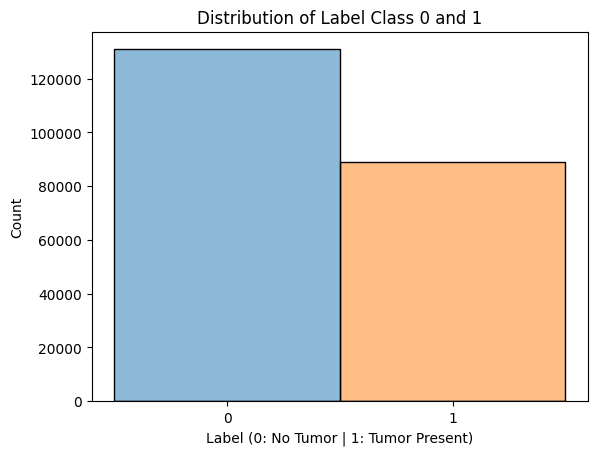

In [15]:
# Plot the distribution of the Label Classes for 0 and 1
sns.histplot(data=labels,
             x="label",
             hue="label",
             legend=False,
             discrete=True,
             binwidth=0.6)
plt.xticks([0,1])
plt.xlabel("Label (0: No Tumor | 1: Tumor Present)")
plt.title("Distribution of Label Class 0 and 1")
plt.show()

In [16]:
if "labels" in locals():
    X = labels["id"]
    y = labels["label"]

    # Create a test and training set from the original dataframe
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

    # Further examine class distribution and display
    print("\nClass distribution in the training set:")
    print(y_train.value_counts(normalize=True))
train_image_folder = os.path.join(destination_folder, "train")

Training samples: 176020, Testing samples: 44005

Class distribution in the training set:
label
0    0.594995
1    0.405005
Name: proportion, dtype: float64


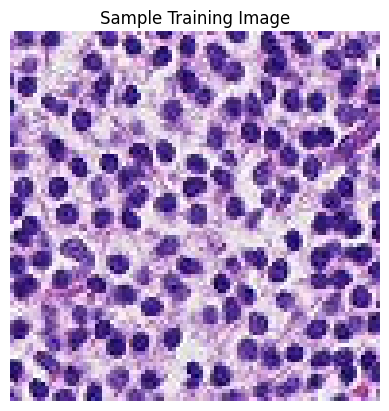

In [17]:
# Confirm that the overall path to the `train_image_folder` exists, and open
# the image to examine a sample training image
if os.path.exists(train_image_folder):
    sample_image = os.path.join(train_image_folder, X_train.iloc[0] + ".tif")
    if os.path.exists(sample_image):
        from PIL import Image

        image = Image.open(sample_image)
        plt.imshow(image)
        plt.axis("off")
        plt.title("Sample Training Image")
        plt.show()
    else:
        print(f"Sample image {sample_image} not found.")
else:
    print("Train image folder not found.")

In [18]:
# Add ".tif" to the label `id` and change `label` a string for processing
labels["id"] = labels["id"] +".tif"
labels["label"] = labels["label"].astype(str)

In [19]:
# Create a data generator for preprocessing data in batches
datagen = ImageDataGenerator(
    rescale = 1/255, # Normalize pixel on scale of 0-1
    validation_split = 0.2 # Split data into training and validation sets
)
# Create path to training image folder
train_image_folder = os.path.join(destination_folder, "train")

# Create a training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=train_image_folder,
    x_col = "id",
    y_col = "label",
    target_size = (32,32),
    batch_size = 32,
    class_mode="binary",
    subset = "training"
)

# Create a validation generator
val_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=train_image_folder,
    x_col = "id",
    y_col = "label",
    target_size = (32,32),
    batch_size = 32,
    class_mode="binary",
    subset = "validation"
)
# Verify generator works and examine number of samples
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Training samples: 176020
Validation samples: 44005


## Baseline Model:

The architecture for the baseline model is detailed below:

1. **Input Layer:** Takes images of shape 32 x 32 pixels with 3 color channels (RGB)

2. **Convolutional Layers:**
  *  **First Convolutional Layer:** 32 filters with kernel size (3,3). ReLU Activation.
  *  **Max Pooling Layer:** Reduce spatial dimensions by a factor of 2.
  *  **Second Convolutional Layer:** 64 filters with a kernel size of (3,3) Relu Activation.

3. **Flatten Layer:** Converts the two dimensional feature maps from the last convolutional layer into a single dimension vector.

4. **Dense Layers:**
  * **First Dense Layer:** Fully connected; 128 neurons and ReLU activation.
  * **Output Layer:** Single neuron with a sigmoid activation.

5. **Optimizer:** Utilizes an Adam Optimizer with a Loss Function of Binary Crossentropy.




In [20]:
# Create the Baseline Model
baseline_model = Sequential([
    Conv2D(32, (3,3), activation = "relu", input_shape = (32,32,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation = "relu"),

    Flatten(),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")
  ])

# Optimize the model and gather accuracy metrics
baseline_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print the Baseline Model summary
baseline_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,384,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,404,097 (5.36 MB)

 Trainable params: 1,404,097 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the Baseline Model
history_baseline = baseline_model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 10,
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 159s 28ms/step - accuracy: 0.7703 - loss: 0.4826 - val_accuracy: 0.8175 - val_loss: 0.4138
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 149s 27ms/step - accuracy: 0.8225 - loss: 0.3996 - val_accuracy: 0.8368 - val_loss: 0.3733
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 148s 27ms/step - accuracy: 0.8358 - loss: 0.3721 - val_accuracy: 0.8449 - val_loss: 0.3559
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 149s 27ms/step - accuracy: 0.8412 - loss: 0.3622 - val_accuracy: 0.8509 - val_loss: 0.3463
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 148s 27ms/step - accuracy: 0.8493 - loss: 0.3442 - val_accuracy: 0.8491 - val_loss: 0.3517
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 149s 27ms/step - accuracy: 0.8542 - loss: 0.3382 - val_accuracy: 0.8500 - val_loss: 0.3470
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 148s 27ms/step - accuracy: 0.8602 - loss: 0.3219 - val_accuracy: 0.8498 - val_loss: 0.3474
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 148s 27ms/step - accuracy: 0.8681 - lo

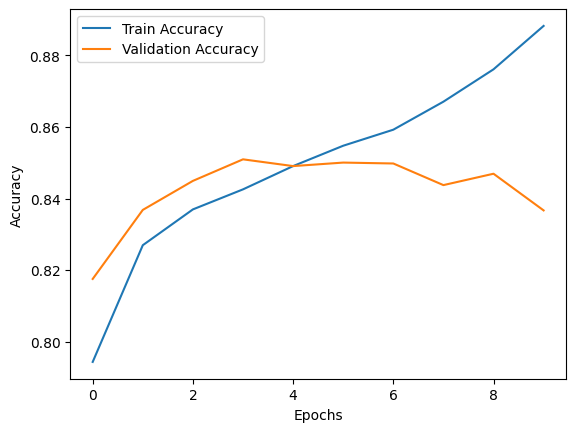

In [22]:
# Create a plot for the Training Accuracy and Validation Accuracy vs. Epochs
plt.plot(history_baseline.history['accuracy'], label='Train Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

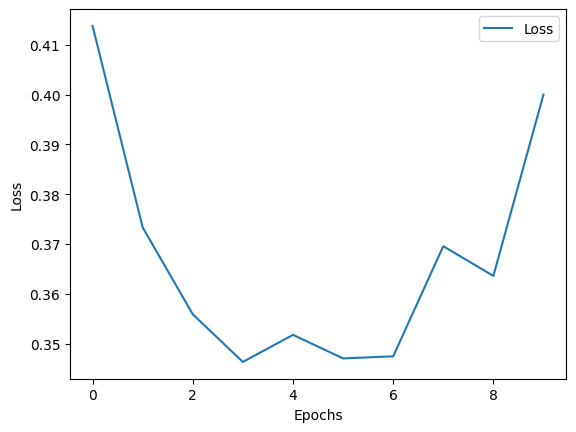

In [23]:
# Create a plot for the Loss vs. Epochs
plt.plot(history_baseline.history['val_loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Evaluate the Baseline Model on Validation Data
val_loss, val_accuracy = baseline_model.evaluate(val_generator)
print(f"Validation Loss = {val_loss:.2f}, Validation Acc. = {val_accuracy:.2f}")

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.8369 - loss: 0.4016
Validation Loss = 0.40, Validation Acc. = 0.84


## 1st Advanced Model (Model 1):

The architecture for the first advanced model (Model 1) is detailed below:

1. **Input Layer:** Takes images of shape 32 x 32 pixels with 3 color channels (RGB)

2. **Convolutional Layers:**

 *  **First Convolutional Layer:** 32 filters with kernel size (3,3). ReLU Activation.
 *  **Max Pooling Layer 1:** Reduce spatial dimensions by a factor of 2.
 *  **Second Convolutional Layer:** 64 filters with a kernel size of (3,3) Relu Activation.
 * **Max Pooling Layer 2:** Reduce spatial dimensions by a factor of 2.
 * **Third Convolutional Layer:** 128 filters with a kernel size of (3,3) Relu Activation.


3. **Flatten Layer:** Converts the feature maps from the last convolutional layer into a single dimension vector.

4. **Dense Layers:**

  * **First Dense Layer:** Fully connected; 128 neurons and ReLU activation.
  * **Output Layer:** Single neuron with a sigmoid activation.
  * **Dropout:** A dropout value of 0.5 was added to prevent overfitting.

5. **Optimizer:** Utilizes an Adam Optimizer with a Loss Function of Binary Crossentropy.


In [25]:
# Create the first advanced model (Model 1)
model1 = Sequential([
    Conv2D(32, (3,3), activation = "relu", input_shape = (32,32,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation = "relu"),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation = "relu"),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5), # Add a dropout value
    Dense(1, activation="sigmoid")
  ])

# Optimize the model and gather accuracy metrics
model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print the Model 1 summary
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,649 (1.36 MB)

 Trainable params: 355,649 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train Model 1
history1 = model1.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 10,
)


Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 155s 28ms/step - accuracy: 0.7701 - loss: 0.4899 - val_accuracy: 0.8204 - val_loss: 0.3993
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 148s 27ms/step - accuracy: 0.8214 - loss: 0.4066 - val_accuracy: 0.8358 - val_loss: 0.3700
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 149s 27ms/step - accuracy: 0.8345 - loss: 0.3783 - val_accuracy: 0.8367 - val_loss: 0.3701
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 149s 27ms/step - accuracy: 0.8423 - loss: 0.3632 - val_accuracy: 0.8398 - val_loss: 0.3687
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 148s 27ms/step - accuracy: 0.8481 - loss: 0.3523 - val_accuracy: 0.8335 - val_loss: 0.3770
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 148s 27ms/step - accuracy: 0.8510 - loss: 0.3469 - val_accuracy: 0.8406 - val_loss: 0.3580
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 148s 27ms/step - accuracy: 0.8539 - loss: 0.3396 - val_accuracy: 0.8560 - val_loss: 0.3365
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 148s 27ms/step - accuracy: 

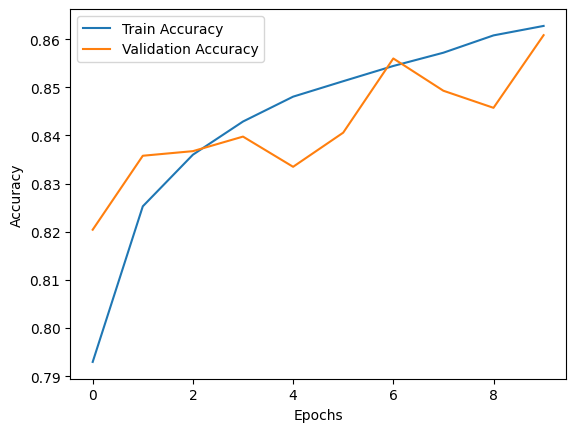

In [27]:
# Create a plot for the Training Accuracy and Validation Accuracy vs. Epochs
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

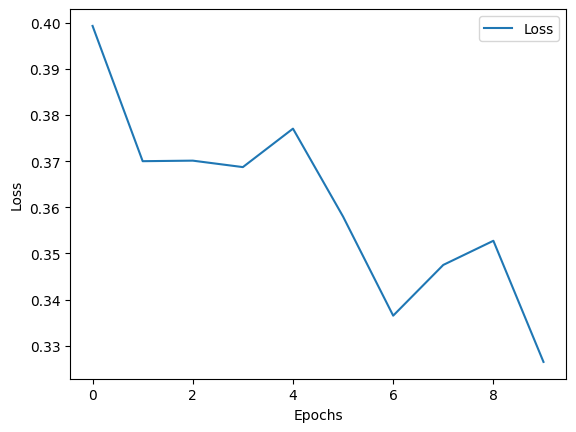

In [28]:
# Create a plot for the Loss vs. Epochs
plt.plot(history1.history['val_loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# Evaluate Model 1 on Valdiation Data
val_loss, val_accuracy = model1.evaluate(val_generator)
print(f"Validation Loss = {val_loss:.2f}, Validation Acc. = {val_accuracy:.2f}")

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.8603 - loss: 0.3276
Validation Loss = 0.33, Validation Acc. = 0.86


## 2nd Advanced Model (Model 2):

The architecture for the second advanced model (Model 2) is detailed below:

1. **Input Layer:** Takes images of shape 32 x 32 pixels with 3 color channels (RGB)

2. **Convolutional Layers:**

 *  **First Convolutional Layer:** 32 filters with kernel size (3,3). ReLU Activation.
 *  **Max Pooling Layer 1:** Reduce spatial dimensions by a factor of 2.
 *  **Second Convolutional Layer:** 64 filters with a kernel size of (3,3) Relu Activation.
 * **Max Pooling Layer 2:** Reduce spatial dimensions by a factor of 2.
 * **Third Convolutional Layer:** 128 filters with a kernel size of (3,3) Relu Activation.


3. **Flatten Layer:** Converts the feature maps from the last convolutional layer into a single dimension vector.

4. **Dense Layers:**

  * **First Dense Layer:** Fully connected; 128 neurons and ReLU activation.
  * **Output Layer:** Single neuron with a sigmoid activation.
  * **Dropout:** A dropout value of 0.5 was added to prevent overfitting.

5. **Optimizer:** Utilizes an Adam Optimizer with a Loss Function of Binary Crossentropy. The learning rate of the Adam Optimizer was adjusted to 0.0005 based on the Model 1 Loss vs. Epochs graph indicating some fluctuations.


In [30]:
# Create Model 2
model2 = Sequential([
    Conv2D(32, (3,3), activation = "relu", input_shape = (32,32,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation = "relu"),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation = "relu"),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5), # Same dropout value
    Dense(1, activation="sigmoid")
  ])

# Optimize the model and gather accuracy metrics; adjust the learning rate
# based on information gathered from Model 1
model2.compile(optimizer=Adam(learning_rate=0.0005), loss="binary_crossentropy", metrics=["accuracy"])

# Print the Model 2 Summary
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,649 (1.36 MB)

 Trainable params: 355,649 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train Model 2
history2 = model2.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 10,
)


Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 154s 27ms/step - accuracy: 0.7720 - loss: 0.4855 - val_accuracy: 0.8098 - val_loss: 0.4299
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 150s 27ms/step - accuracy: 0.8236 - loss: 0.4004 - val_accuracy: 0.8401 - val_loss: 0.3647
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 149s 27ms/step - accuracy: 0.8361 - loss: 0.3747 - val_accuracy: 0.8483 - val_loss: 0.3493
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 149s 27ms/step - accuracy: 0.8445 - loss: 0.3572 - val_accuracy: 0.8491 - val_loss: 0.3486
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 150s 27ms/step - accuracy: 0.8534 - loss: 0.3411 - val_accuracy: 0.8557 - val_loss: 0.3329
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 150s 27ms/step - accuracy: 0.8572 - loss: 0.3322 - val_accuracy: 0.8558 - val_loss: 0.3325
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 149s 27ms/step - accuracy: 0.8641 - loss: 0.3174 - val_accuracy: 0.8606 - val_loss: 0.3251
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 150s 27ms/step - accuracy: 

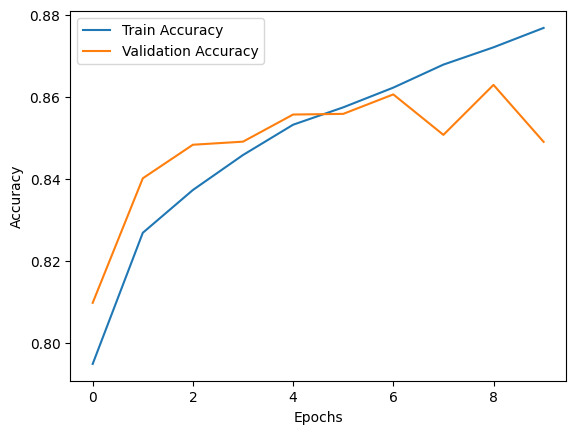

In [32]:
# Create a plot for the Training Accuracy and Validation Accuracy vs. Epochs
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

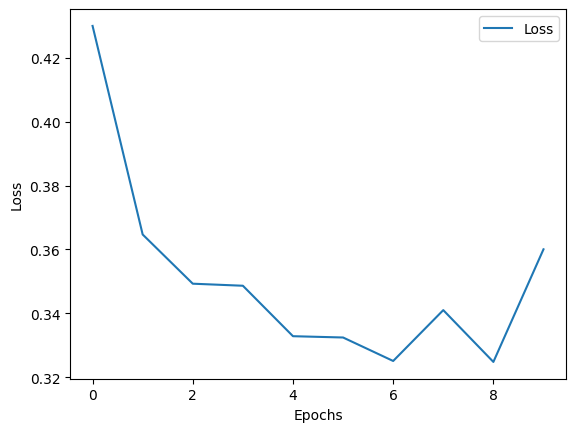

In [33]:
# Create a plot for the Loss vs. Epochs
plt.plot(history2.history['val_loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
# Evaluate Model 2 on Validation Data
val_loss, val_accuracy = model2.evaluate(val_generator)
print(f"Validation Loss = {val_loss:.2f}, Validation Acc. = {val_accuracy:.2f}")

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.8533 - loss: 0.3506
Validation Loss = 0.36, Validation Acc. = 0.85


## Model Analysis and Confusion Matrix Generation

In [66]:
val_predictions = model2.predict(val_generator)
val_predictions = (val_predictions > 0.5).astype(int).flatten()

val_labels = val_generator.classes

val_ids = val_generator.filenames
val_ids = [os.path.splitext(os.path.basename(f))[0] for f in val_ids]

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step


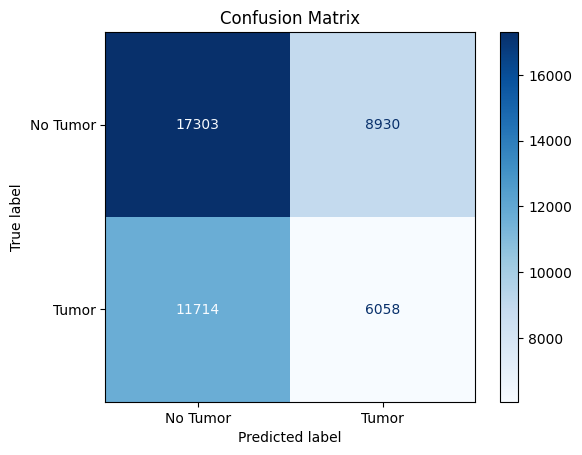

In [67]:
cm = confusion_matrix(val_labels, val_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["No Tumor", "Tumor"])
cm_display.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [68]:
submission = pd.DataFrame({
    "id": val_ids,
    "label": val_predictions
})
submission.to_csv("submission.csv", index=False)
print("Submission Saved as submission.csv")

Submission Saved as submission.csv


In [69]:
submission.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,0
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,1


## Conclusions:

- The model with the 3 convolutional layers and the adjusted learning rate indicated the highest accuracy and lowest validation loss at 0.87 Validation Accuracy and 0.31 Validation Loss. The baseline model performed with an accuracy of 0.84 Validation Accuracy and 0.40 for the Validation Loss. The model with the unadjusted learning rate that included the baseline model with a 3rd convolutional layer and a dropout of 0.5 performed with an accuracy of 0.86 Validation Accuracy and 0.33 Validation Loss. While the Model 2 performance was the best, all three models performed very similarly.


## Next Steps:

- Additional hyperparameters could be adjusted to provide better accuracy. This could include adjusting the filter size, adding additional convolutional layers, further tuning the learning rate, and much further. Leveraging transfer learning via an advanced CNN architecture, such as ResNet, could also potentially improve the performance of models.

In [45]:
!kaggle competitions submit -c histopathologic-cancer-detection -f submission.csv -m "Message"

100% 2.36M/2.36M [00:03<00:00, 769kB/s]
Successfully submitted to Histopathologic Cancer Detection